In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

In [46]:
def generate_random_weighted_graph(n, low, high):
    g = nx.generators.complete_graph(n)

    g.add_weighted_edges_from([
        (u, v, np.random.randint(low, high))
        for u, v in g.edges()
    ])

    nx.set_node_attributes(g, nx.spring_layout(g), "pos")
    return g

In [55]:
def plot_graph(g, title="", highlight_edges=[]):
    pos = nx.get_node_attributes(g, "pos")
    plt.figure(figsize=(17, 17))

    plt.title(title)
    nx.draw(g, pos=pos, labels={x:x for x in g.nodes}, width=2)

    weights = nx.get_edge_attributes(g, "weight")

    nx.draw_networkx_edge_labels(g, pos, edge_labels=weights, label_pos=.4)

    nx.draw_networkx_edges(g, pos, edgelist=highlight_edges, edge_color="r", width=3)

    nx.draw_networkx_edge_labels(
        g, 
        pos, 
        edge_labels={
            e: w 
            for e, w in weights.items() 
            if e in map(lambda x: tuple(sorted(x)), highlight_edges)
        }, 
        font_color="r", 
        label_pos=.4
    )
    plt.show()

def roulette_wheel_selection(fitness_func,parents):
    fitness = np.array(list(map(fitness_func,parents)))
    fitness = fitness/fitness.sum()
    n = len(parents)
    return [parents[i] for i in np.random.choice(n,n,p=fitness)]


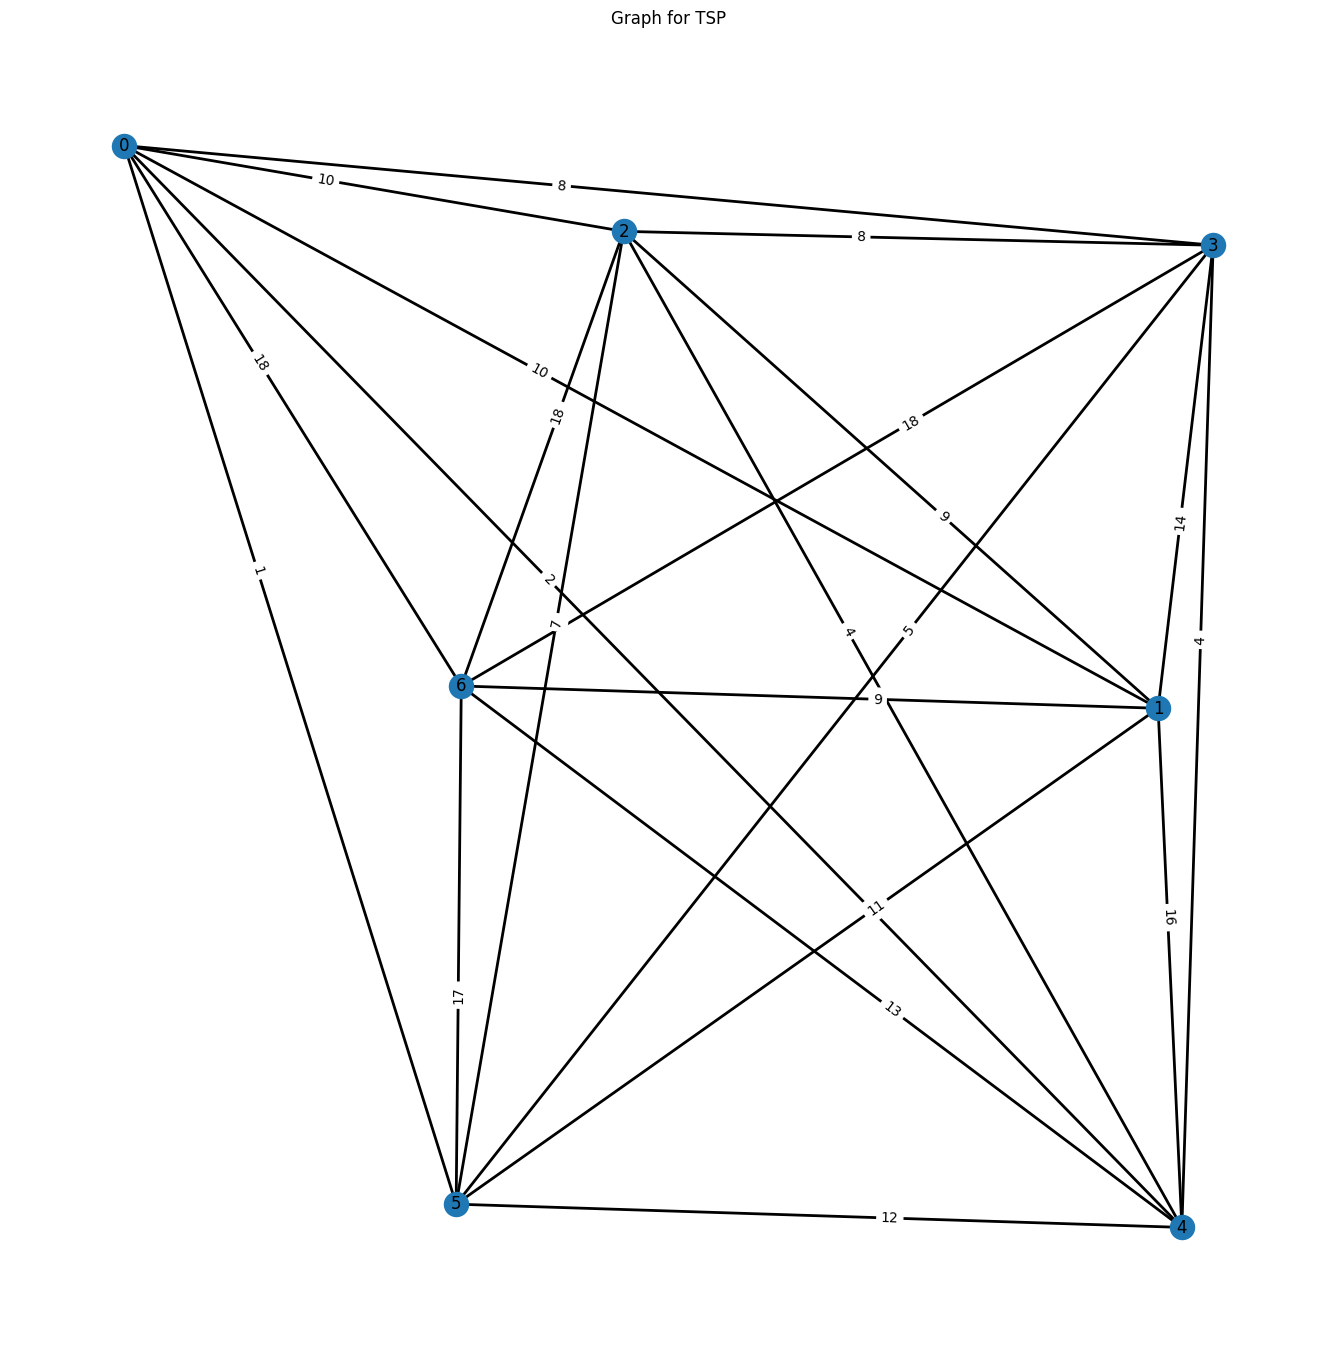

In [56]:
g = generate_random_weighted_graph(7, 1, 20)

plot_graph(g, "Graph for TSP")

In [57]:
def nearest_neighbour_initialization(g, closed_tour=False):
    curr_node = int(np.random.choice(g.nodes))
    path = [curr_node]

    not_visited = set(g.nodes) - {curr_node}

    while not_visited:
        not_visited_neigbors = not_visited & set(g.neighbors(curr_node))
        key = lambda x: g[curr_node][x]["weight"]
        curr_node = min(not_visited_neigbors, key=key)
        path.append(curr_node)
        not_visited.remove(curr_node)

    if closed_tour:
        path.append(path[0])

    return path

np.random.seed(1)
print(nearest_neighbour_initialization(g))
print(nearest_neighbour_initialization(g, True))

[5, 0, 4, 2, 3, 1, 6]
[3, 4, 0, 5, 2, 1, 6, 3]


In [79]:
from collections import defaultdict

def has_cycle(g):
    try:
        nx.find_cycle(g)
    except nx.NetworkXNoCycle:
        return False
    return True

def get_path_from_edges(edges, closed_tour=False):
    path_graph = nx.Graph(edges)

    curr = min(path_graph, key=path_graph.degree)

    path, visited = [curr], {curr}

    while len(path) < len(path_graph):
        curr = (set(path_graph.neighbors(curr)) - visited).pop()
        visited.add(curr)
        path.append(curr)

    if closed_tour:
        path.append(path[0])

    return path
    
def select_stochastic(a,key,inverse=True):
    a = list(a)
    probs = np.array(list(map(key,a)))
    if inverse:
        probs = 1/np.array(probs)
    probs = probs/probs.sum()
    return type(a[0])(a[np.random.choice(len(a),p=probs)])

def shortest_edge_initialization(g, closed_tour=False, stochastic=True):
    edge_list = set(g.edges)

    times_visited = defaultdict(int)
    tour = set()
    max_tour_len = len(g) if closed_tour else len(g) - 1
    key = nx.get_edge_attributes(g, "weight").get

    while len(tour) < max_tour_len:
        if not stochastic:
            u, v = min(edge_list, key=key)
        else:
            u, v = select_stochastic(edge_list, key=key)
        times_visited[u] += 1
        times_visited[v] += 1

        tour.add((u, v))

        edge_list.remove((u,v))
        for u, v in set(edge_list):
            if (
                (has_cycle(nx.Graph(tour|{(u, v)})) and len(tour) != len(g) - 1)
                or times_visited[u] == 2 or times_visited[v] == 2
            ):
                edge_list.remove((u,v))

    return get_path_from_edges(tour, closed_tour=closed_tour)

np.random.seed(1)
print(shortest_edge_initialization(g))
print(shortest_edge_initialization(g, True))
    

[6, 1, 3, 4, 0, 5, 2]
[2, 1, 6, 3, 5, 0, 4, 2]


In [95]:
def make_valid_tour(p, nodes):
    unvisited = set(nodes) - set(p)
    indices = defaultdict(list)

    for i in range(len(p)):
        indices[p[i]].append(i)
    visited_twice = { node for node in indices if len(indices[node]) == 2 }
    for node in visited_twice:
        change_index = np.random.choice(indices[node])
        p[change_index] = unvisited.pop()

    return p

def partially_matched_crossover(p1, p2):
    pt = np.random.randint(1, len(p1)-1)
    c1 = p1[:pt] + p2[pt:]
    c2 = p2[:pt] + p1[pt:]


    nodes = set(p1)
    return make_valid_tour(c1, nodes), make_valid_tour(c2, nodes)

inv_path_length = lambda x: 1/nx.path_weight(g,x,"weight")


n_population = 8
population = [
    shortest_edge_initialization(g, closed_tour=False, stochastic=True)
    for _ in range(n_population)
]  

selected_population = roulette_wheel_selection(inv_path_length, population)
parents = selected_population[:2]

print(parents)

print(partially_matched_crossover(*parents))

[[6, 5, 0, 4, 2, 3, 1], [4, 2, 1, 5, 0, 3, 6]]
([1, 5, 0, 4, 2, 3, 6], [4, 2, 1, 5, 0, 3, 6])


In [87]:
def order_crossover(p1, p2):
    start = np.random.randint(0, len(p1) - 1)
    end = np.random.randint(start + 1, len(p1) if start != 0 else len(p1) - 1)

    def fill_blanks(p1, p2, s, e):
        unvisited_nodes = p2.copy()

        for node in p1[s:e]:
            unvisited_nodes.remove(node)

        c = p1.copy()
        for i in range(len(p1)):
            if i < s or i >=e:
                c[i] = unvisited_nodes.pop(0)
        return c

    c1 = fill_blanks(p1, p2, start, end)
    c2 = fill_blanks(p2, p1, start, end)

    return c1, c2
   
n_population = 8
population = [shortest_edge_initialization(g, closed_tour=False) for _ in range(n_population)]

selected_population = roulette_wheel_selection(inv_path_length, population)
parents = selected_population[:2]

print(parents)
print(order_crossover(*parents))

[[1, 5, 3, 0, 4, 2, 6], [3, 2, 4, 0, 5, 1, 6]]
([3, 5, 1, 0, 4, 2, 6], [3, 4, 2, 0, 5, 1, 6])


In [61]:
def inversion_mutation(p):
    start = np.random.randint(1, len(p) - 1)
    end = np.random.randint(start+1, len(p) + 1)
    print(start, end)
    c = p.copy()

    c[start:end] = reversed(c[start:end])
    return c

n_population = 8
population = [
    shortest_edge_initialization(g, closed_tour=False)
    for _ in range(n_population)
]

subject = population[0]
print(subject, inversion_mutation(subject), sep="\n")

1 7
[3, 4, 0, 5, 2, 1, 6]
[3, 6, 1, 2, 5, 0, 4]


In [62]:
def insertion_mutation(p):
    i = np.random.randint(1, len(p))
    k = np.random.randint(0, len(p) - 1)

    print(i, k)
    c = p.copy()
    c.insert(k, c.pop(i))
    return c

n_population = 8 
population = [
    shortest_edge_initialization(g, closed_tour=False)
    for _ in range(n_population)
]

subject = population[0]

print(subject, insertion_mutation(subject), sep="\n")

2 1
[3, 4, 0, 5, 2, 1, 6]
[3, 0, 4, 5, 2, 1, 6]
